## Create data set for model

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [141]:
exp_root_dir = Path('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/experiments/multi_plnt_sys_probing')

### Importing source dataset

In [142]:
df = pd.read_csv('/Users/msaragoc/Library/CloudStorage/OneDrive-NASA/Projects/exoplanet_transit_classification/experiments/multi_plnt_sys_probing/processed_datasets/01-23-2023_1220/confirmed_kois_gaia_stellar.csv')
df

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_mag_diff
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.046,b'DSEP',2,2,2,14.082,13.751,13.648,b'conf',-0.038088
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,2018-08-16,CANDIDATE,0.969,0,0,...,-0.046,b'DSEP',2,2,2,14.082,13.751,13.648,b'conf',-0.038088
2,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.136,b'DSEP',1,1,1,14.366,14.064,13.952,b'conf',-0.023555
3,10872983,K00756.01,Kepler-228 d,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.150,b'DSEP',3,3,3,14.528,14.113,14.132,b'conf',-0.021539
4,10872983,K00756.02,Kepler-228 c,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.150,b'DSEP',3,3,3,14.528,14.113,14.132,b'conf',-0.021539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,10736489,K07368.01,Kepler-1974 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.077,b'DSEP',0,1,6,11.296,10.884,10.794,b'cand',-0.088860
2658,7350067,K06863.01,Kepler-1646 b,CONFIRMED,Done,2018-08-16,CANDIDATE,1.000,0,0,...,-0.025,b'DSEP',1,1,7,12.872,12.298,12.029,b'conf',-0.103955
2659,8311864,K07016.01,Kepler-452 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0.771,0,0,...,-0.109,b'DSEP',1,1,1,12.263,11.919,11.852,b'conf',-0.033091
2660,7935997,K05447.02,Kepler-1629 b,CONFIRMED,Done,2018-08-16,CANDIDATE,0.000,0,0,...,-0.073,b'DSEP',1,2,1,11.595,11.302,11.218,b'conf',-0.046711


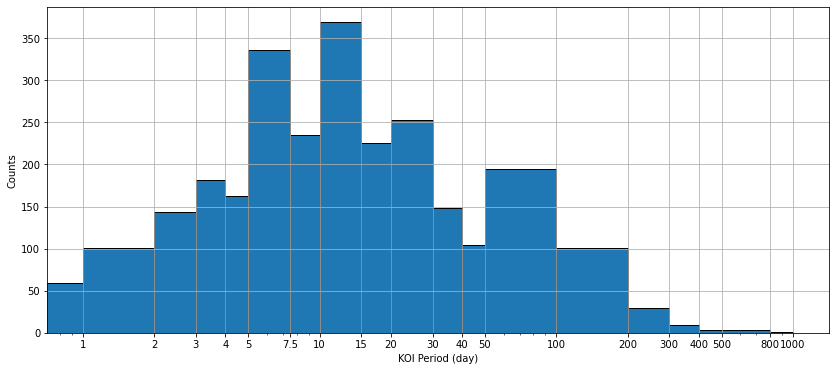

In [143]:
# plot histogram of orbital periods

bins = [0, 1, 2, 3, 4, 5, 7.5, 10, 15, 20, 30, 40, 50, 100, 200, 300, 400, 500, 800, 1000]
f = plt.figure(figsize=(14, 6))
ax = df['koi_period'].hist(bins=bins, edgecolor='k', cumulative=False)
ax.set_xlabel('KOI Period (day)')
ax.set_xscale('log')
ax.set_ylabel('Counts')
# ax.set_xscale('log')
ax.set_xticks(bins[1:])
ax.set_xticklabels(bins[1:]);

### Make constrained data set

In [144]:
# check how many planets have a period >= 330 days
period_cutoff = 330
print((df['koi_period'] >= period_cutoff).sum(), len(df))

# remove planets with period
df = df.loc[df['koi_period'] < period_cutoff]

print(f'Number of examples: {len(df)}')
# confirm change
print(f'Max period: {df["koi_period"].max()}')

14 2662
Number of examples: 2648
Max period: 328.240201


### Deal with missing values in the data

In [145]:
features_names = [
    'koi_prad',
    'koi_period',
    'koi_incl',
    'radius',
    'mass',
    'feh',
    'teff'
]

for feature_name in features_names:
    missing_feat_df = df.loc[df[feature_name].isna(),['kepoi_name', feature_name]]
    print(f'Found {len(missing_feat_df)} examples with missing feature {feature_name}')
    if len(missing_feat_df) > 0:
        print(missing_feat_df)

Found 2 examples with missing feature koi_prad
     kepoi_name  koi_prad
1413  K00245.04       NaN
2657  K07368.01       NaN
Found 0 examples with missing feature koi_period
Found 2 examples with missing feature koi_incl
     kepoi_name  koi_incl
1413  K00245.04       NaN
2657  K07368.01       NaN
Found 0 examples with missing feature radius
Found 0 examples with missing feature mass
Found 0 examples with missing feature feh
Found 0 examples with missing feature teff


### Impute missing values

In [146]:
# found planet radius on public databases on the web
# set inclinination to placeholder for missing value...
df.loc[df['kepoi_name'] == 'K00245.04', ['koi_prad', 'koi_incl']] = [0.37, 0]
df.loc[df['kepoi_name'] == 'K07368.01', ['koi_prad', 'koi_incl']] = [0.198 * 11.2, 0]  # 1 J_rad = 11.2 E_rad

# confirm change
df.loc[df['kepoi_name'].isin(['K00245.04', 'K07368.01']), ['kepoi_name', 'koi_prad', 'koi_incl']]

/Users/msaragoc/opt/anaconda3/envs/exoplnt_dl/lib/python3.8/site-packages/pandas/core/indexing.py:1797: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, v, pi)


,kepoi_name,koi_prad,koi_incl
1413,K00245.04,0.3700,0.0
2657,K07368.01,2.2176,0.0


### Sort data set by KIC ID and period

In [147]:
df = df.sort_values(by=['kepid','koi_period'], ascending = [True, True])
df = df.reset_index(drop=True)
df[['kepid', 'kepoi_name', 'koi_period']]

,kepid,kepoi_name,koi_period
0,757450,K00889.01,8.884923
1,1026957,K00958.01,21.761298
2,1161345,K00984.01,4.287467
3,1432789,K00992.01,9.931463
4,1718189,K00993.02,13.060794
...,...,...,...
2643,12735740,K03663.01,282.525356
2644,12735830,K03311.01,31.827649
2645,12784167,K03848.01,1.847893
2646,12785320,K00298.01,19.963672


### Add fake inner- and outer-most planets to the data set

In [148]:
unique_kepids = df['kepid'].unique()

# planet parameters for fake planets
fake_koi_prad = 0
fake_koi_incl = 0
fake_inner_period = df["koi_period"].min()
fake_outer_period = df["koi_period"].max()

df_wfake_kois = []
for kepid in unique_kepids:  # iterate through each target

    # get all KOIs for the target
    kois_in_target_df = df.loc[df['kepid'] == kepid]

    # get KOI ID for host star
    koi_kepid = kois_in_target_df['kepoi_name'].values[0].split('.')[0]

    # create inner- and outer-most fake KOIs
    inner_fake_koi = kois_in_target_df.iloc[0].to_frame().T
    inner_fake_koi[['koi_prad', 'koi_incl', 'koi_period']] = fake_koi_prad, fake_koi_incl, fake_inner_period
    inner_fake_koi['kepoi_name'] = f'{koi_kepid}.inner'

    outer_fake_koi = kois_in_target_df.iloc[0].to_frame().T
    outer_fake_koi[['koi_prad', 'koi_incl', 'koi_period']] = fake_koi_prad, fake_koi_incl, fake_outer_period
    outer_fake_koi['kepoi_name'] = f'{koi_kepid}.outer'

    # add fake KOIs to KOI set for the host star
    kois_in_target_wfake_df = pd.concat([inner_fake_koi, kois_in_target_df, outer_fake_koi], axis=0)

    df_wfake_kois.append(kois_in_target_wfake_df)

df_wfake_kois = pd.concat(df_wfake_kois, axis=0)
df_wfake_kois.reset_index()
df_wfake_kois[['kepid', 'kepoi_name', 'koi_period', 'koi_incl', 'koi_prad']]
df_wfake_kois.to_csv(exp_root_dir / 'q1q17_dr25_kois_with_fake.csv', index=False)

### Building data set

In [149]:
dataset_df = []
for kepid in df_wfake_kois['kepid'].unique():

    # get all KOIs for the target
    kois_in_target_df = df_wfake_kois.loc[df_wfake_kois['kepid'] == kepid]
    kois_in_target_df.reset_index(inplace=True)

    examples_in_target = []
    for koi_i in range(1, len(kois_in_target_df) - 1):  # iterate through the kois for the target except the inner- and outer-most fake kois
        # get koi and inner and outer kois adjacent to that koi
        inner_koi = kois_in_target_df.iloc[koi_i - 1]
        outer_koi = kois_in_target_df.iloc[koi_i + 1]
        curr_koi = kois_in_target_df.iloc[koi_i]
        for feature in ['kepoi_name', 'koi_prad', 'koi_incl', 'koi_period']:
            curr_koi[f'{feature}_i-1'] = inner_koi[feature]
            curr_koi[f'{feature}_i+1'] = outer_koi[feature]

        examples_in_target.append(curr_koi.to_frame().T.drop(columns='index'))

    examples_in_target_df = pd.concat(examples_in_target, axis=0)

    dataset_df.append(examples_in_target_df)

dataset_df = pd.concat(dataset_df, axis=0)
dataset_df.reset_index(drop=True, inplace=True)
dataset_df.to_csv(exp_root_dir / 'q1q17dr25_dataset_for_model.csv', index=False)

/Users/msaragoc/opt/anaconda3/envs/exoplnt_dl/lib/python3.8/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
/Users/msaragoc/opt/anaconda3/envs/exoplnt_dl/lib/python3.8/site-packages/pandas/core/indexing.py:1724: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer_missing(indexer, value)


In [150]:
# check data set

features_cols_names = [
    'kepoi_name',
    'koi_period',
    'koi_prad',
    'koi_incl'
]
features_cols_names_inner = [f'{feat_name}_i-1' for feat_name in features_cols_names]
features_cols_names_outer = [f'{feat_name}_i+1' for feat_name in features_cols_names]
features_cols_names_all = features_cols_names + features_cols_names_inner + features_cols_names_outer
dataset_df[['kepid'] + features_cols_names_all]

,kepid,kepoi_name,koi_period,koi_prad,koi_incl,kepoi_name_i-1,koi_period_i-1,koi_prad_i-1,koi_incl_i-1,kepoi_name_i+1,koi_period_i+1,koi_prad_i+1,koi_incl_i+1
0,757450,K00889.01,8.884923,10.51,89.89,K00889.inner,0.341842,0.0,0.0,K00889.outer,328.240201,0.0,0.0
1,1026957,K00958.01,21.761298,2.53,89.95,K00958.inner,0.341842,0.0,0.0,K00958.outer,328.240201,0.0,0.0
2,1161345,K00984.01,4.287467,2.29,88.93,K00984.inner,0.341842,0.0,0.0,K00984.outer,328.240201,0.0,0.0
3,1432789,K00992.01,9.931463,2.41,89.84,K00992.inner,0.341842,0.0,0.0,K00992.outer,328.240201,0.0,0.0
4,1718189,K00993.02,13.060794,1.45,88.16,K00993.inner,0.341842,0.0,0.0,K00993.01,21.853629,1.75,88.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2643,12735740,K03663.01,282.525356,8.98,89.93,K03663.inner,0.341842,0.0,0.0,K03663.outer,328.240201,0.0,0.0
2644,12735830,K03311.01,31.827649,4.98,89.54,K03311.inner,0.341842,0.0,0.0,K03311.outer,328.240201,0.0,0.0
2645,12784167,K03848.01,1.847893,1.51,89.73,K03848.inner,0.341842,0.0,0.0,K03848.outer,328.240201,0.0,0.0
2646,12785320,K00298.01,19.963672,1.5,88.51,K00298.inner,0.341842,0.0,0.0,K00298.outer,328.240201,0.0,0.0


### Comparing distribution of planet properties for singles and multis

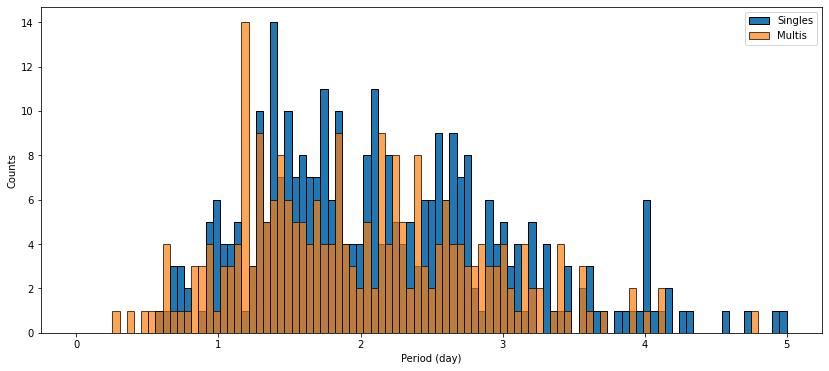

In [173]:
dataset_df = pd.read_csv(exp_root_dir / 'q1q17dr25_dataset_for_model.csv')

planet_cnts_per_target = dataset_df['kepid'].value_counts()
single_targets = planet_cnts_per_target.loc[planet_cnts_per_target == 3].index
singles_df = dataset_df.loc[dataset_df['kepid'].isin(single_targets)]   ## & (dataset_df['kepoi_name'].str.contains('outer')))]
multis_targets = planet_cnts_per_target.loc[planet_cnts_per_target > 3].index
multis_df = dataset_df.loc[dataset_df['kepid'].isin(multis_targets)]

# bins_period = [0, 1, 2, 3, 4, 5, 7.5, 10, 15, 20, 30, 40, 50, 100, 200, 300, 400, 500, 800, 1000]
# bins_period = np.linspace(80, 90, 100, endpoint=True)
bins_period = np.linspace(0, 5, 100, endpoint=True)  # [0, 1, 2, 3, 4, 5, 7.5, 10, 15, 20, 30, 40, 50, 100, 200, 300, 400, 500, 800, 1000]

f, ax = plt.subplots(figsize=(14, 6))
ax.hist(singles_df['koi_prad'], bins_period, edgecolor='k', label='Singles', alpha=1, zorder=1)
ax.hist(multis_df['koi_prad'], bins_period, edgecolor='k', label='Multis', alpha=0.7, zorder=2)
ax.set_xlabel('Period (day)')
ax.set_ylabel('Counts')
# ax.set_xscale('log')
ax.legend()
# ax.set_xticks(bins_period[1:])
# ax.set_xticklabels(bins_period[1:]);

### Splitting data set into training, validation, and test sets

In [157]:
# split by target star
unique_kepids = dataset_df['kepid'].unique()
np.random.shuffle(unique_kepids)
n_kepids = len(unique_kepids)

split_ratios = [0.8, 0.1, 0.1]
train_kepids = unique_kepids[:int(split_ratios[0] * n_kepids)]
val_kepids = unique_kepids[int(split_ratios[0] * n_kepids): int((sum(split_ratios[:2])) * n_kepids)]
test_kepids = unique_kepids[int((sum(split_ratios[:2])) * n_kepids):]

train_df = dataset_df.loc[dataset_df['kepid'].isin(train_kepids)].reset_index(inplace=False, drop=True)
val_df = dataset_df.loc[dataset_df['kepid'].isin(val_kepids)].reset_index(inplace=False, drop=True)
test_df = dataset_df.loc[dataset_df['kepid'].isin(test_kepids)].reset_index(inplace=False, drop=True)

train_df.to_csv(exp_root_dir / 'train_set.csv', index=False)
val_df.to_csv(exp_root_dir / 'val_set.csv', index=False)
test_df.to_csv(exp_root_dir / 'test_set.csv', index=False)

In [158]:
print(f'Size of training set: {len(train_df)}')
print(f'Size of validation set: {len(val_df)}')
print(f'Size of test set: {len(test_df)}')

Size of training set: 2147
Size of validation set: 244
Size of test set: 257
